In [612]:
import numpy as np
import math
import struct
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
%matplotlib inline

Make sure data is in float32

In [613]:
stuff=np.fromfile('/home/jwb/bits.txt',dtype='float32')
header=np.fromfile('./header.dat',dtype='float32')

Take real and imaginary parts of complex signal

In [614]:
arr1=stuff[::2]
arr2=stuff[1::2]

In [615]:
arr1_trim = arr1[23000:33000]
arr2_trim = arr2[23000:33000]

Make a complex signal

In [616]:
signal=arr1+(1j * arr2 )
signal_trim = arr1_trim + 1j*arr2_trim

Real signal plot

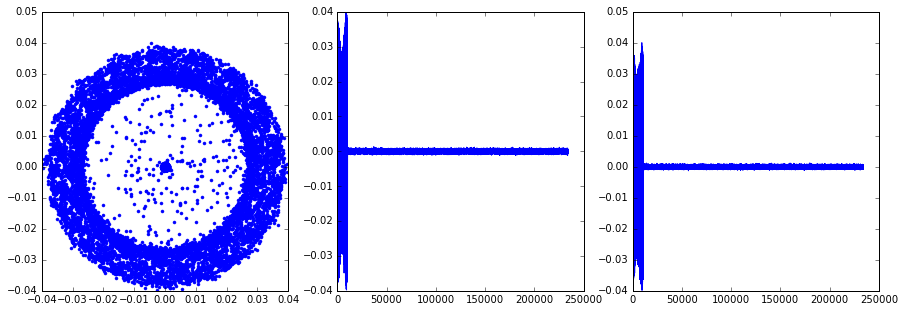

In [636]:
fullPlot(signal[39241:])

Calculate the frequency axis of the fft, then calculate the fft of the signal squared. Half of the frequency of the spike is an approximation of the frequency offset.

/home/jwb/anaconda3/lib/python3.5/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


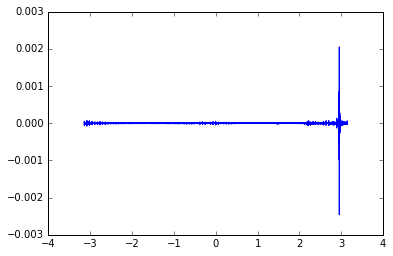

In [618]:
freq_data=np.fft.fftshift(np.fft.fft(signal_trim**4))
freq_axis=np.fft.fftfreq(len(signal_trim),(1/22050))
rad_axis= np.linspace(-np.pi, np.pi*(len(signal_trim)-1)/len(signal_trim), len(freq_data))
plt.plot(rad_axis,freq_data)

In [619]:
freq_offset=np.argmax(freq_data)/4
print("The frequency offset is {:06.2f} hertz".format(freq_axis[np.argmax(freq_data)]/4))
offset = rad_axis[np.argmax(freq_data)]/4
print("The frequency offset is {:06.5f} radians".format(offset))

The frequency offset is -166.48 hertz
The frequency offset is 0.73804 radians


In [620]:
correct=np.linspace(0,len(signal_trim)-1,len(signal_trim))
correct=-np.exp(-1j*correct*offset) 

<function matplotlib.pyplot.axes>

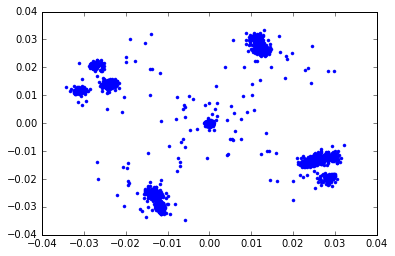

In [621]:
plt.plot(np.real(signal_trim*correct),np.imag(signal_trim*correct), marker='.',linestyle='')
plt.axes

(25000, 35000)

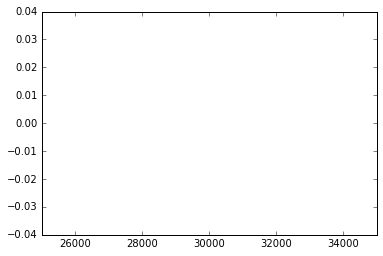

In [622]:
plt.plot(np.real(signal_trim*correct))
plt.xlim(25000,35000)

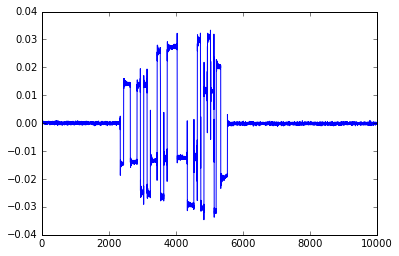

In [623]:
plt.plot(np.imag(signal_trim*correct))

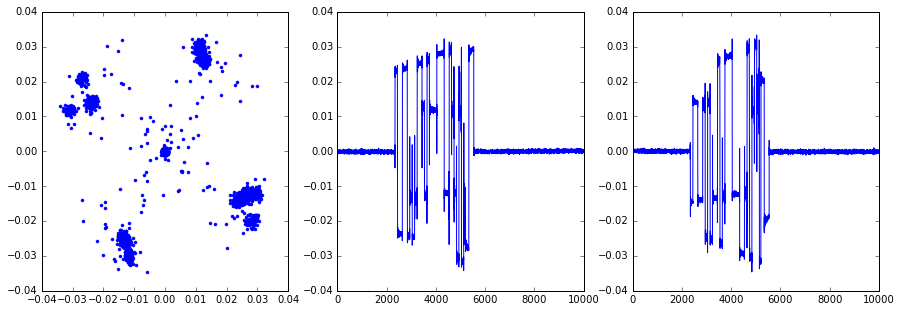

In [624]:
fullPlot(approxPhaseCorrect(signal_trim))

39241


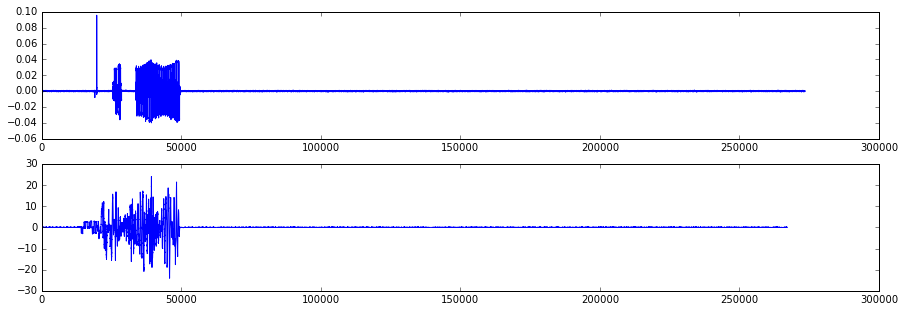

In [643]:
autoTrim(signal,header)

## Functions

In [611]:
def approxPhaseCorrect(raw_sig,rate=22050,verbose=False):
    """Applies a approximate phase correction to a complex signal, returning the corrected signal"""
    duration = len(raw_sig)
    freq_data = np.fft.fftshift(np.fft.fft(raw_sig**4))
    rad_axis= np.linspace(-np.pi, np.pi*(duration-1)/duration, len(freq_data))
    if verbose:
        pass
    offset = rad_axis[np.argmax(freq_data)]/4
    correction = -np.exp(-1j*np.linspace(0,duration-1,duration)*offset)
    return raw_sig*correction

In [582]:
def argand(signal):
    """Plots an argand diagram of a complex signal"""
    plt.plot(np.real(signal),np.imag(signal), marker='.',linestyle='')
    
def fullPlot(signal):
    """Plots an argand diagram of a complex signal, along with the real and complex components in time"""
    plt.figure(figsize=(15,5))
    plt.subplot(131)
    argand(signal)
    
    plt.subplot(132)
    plt.plot(np.real(signal))
    
    plt.subplot(133)
    plt.plot(np.imag(signal))
    
    plt.show()
    


In [642]:
def autoTrim(raw_signal, header):
    signal = approxPhaseCorrect(raw_signal)
    corr_sig = np.correlate(signal, header, mode="valid")
    lag = np.argmax(corr_sig)
    
    plt.figure(figsize=(15,5))
    plt.subplot(211)
    plt.plot(np.real(signal))
    plt.subplot(212)
    plt.plot(np.real(corr_sig))
    print(lag)
    